# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

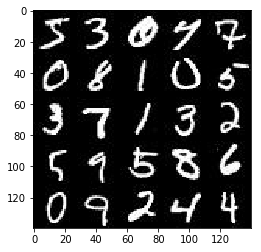

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

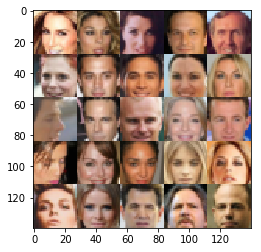

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/Users/ravir/miniconda2/envs/dlnd/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32,shape=())
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images,64, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(x1 * alpha, x1)
       
        # 14x14x64        
        x2 = tf.layers.conv2d(x1,128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)

        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.1
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, kernel_size=5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if batch % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.7208... Generator Loss: 0.0138
Epoch 1/2... Discriminator Loss: 4.0024... Generator Loss: 0.0285
Epoch 1/2... Discriminator Loss: 3.4070... Generator Loss: 0.0524
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 1.3292
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.6782
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 0.6548
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.6799


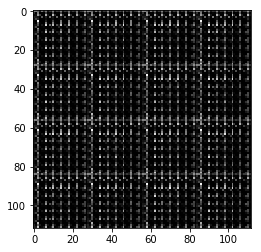

Epoch 1/2... Discriminator Loss: 1.1049... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.9086... Generator Loss: 0.4851
Epoch 1/2... Discriminator Loss: 2.2430... Generator Loss: 0.3225
Epoch 1/2... Discriminator Loss: 1.7513... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.3008... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.5405... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.3272... Generator Loss: 0.7660
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 0.9542


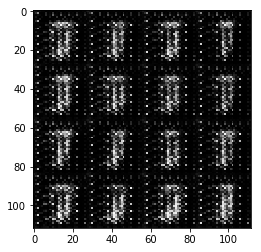

Epoch 1/2... Discriminator Loss: 1.1949... Generator Loss: 0.8878
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.4562... Generator Loss: 0.7094
Epoch 1/2... Discriminator Loss: 1.6480... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.5480... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.7378... Generator Loss: 0.5196
Epoch 1/2... Discriminator Loss: 1.5960... Generator Loss: 0.6543
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.5876... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.7034


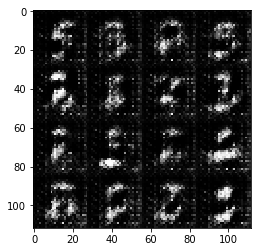

Epoch 1/2... Discriminator Loss: 1.7489... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.7655... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 1.6183... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.6754
Epoch 1/2... Discriminator Loss: 1.4973... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.7401... Generator Loss: 0.5966
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.6407
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.6432


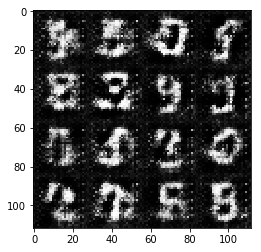

Epoch 1/2... Discriminator Loss: 1.6708... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.4773... Generator Loss: 0.6536
Epoch 1/2... Discriminator Loss: 1.5232... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.8060... Generator Loss: 0.5483
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.7031
Epoch 1/2... Discriminator Loss: 1.5738... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 0.6336
Epoch 1/2... Discriminator Loss: 1.5129... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7293


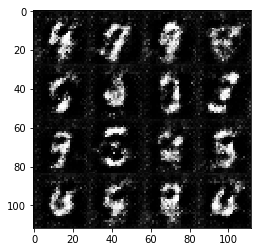

Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.5353... Generator Loss: 0.7079
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.4606... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.4893... Generator Loss: 0.6801
Epoch 1/2... Discriminator Loss: 1.5142... Generator Loss: 0.6765
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.7219
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.6952


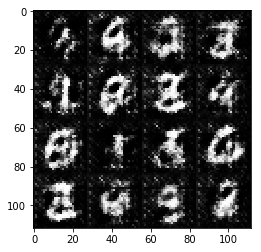

Epoch 1/2... Discriminator Loss: 1.5389... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 1.6891... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7564
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.7151
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.7561


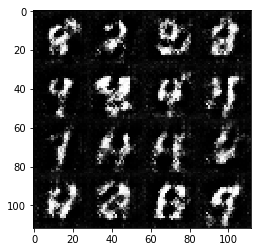

Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.6846... Generator Loss: 0.5456
Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.5267... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.7075
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.8802
Epoch 1/2... Discriminator Loss: 1.2815... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.5349... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 0.6594


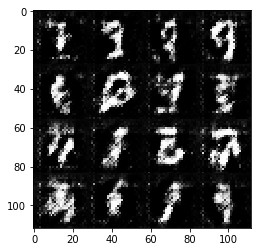

Epoch 1/2... Discriminator Loss: 1.5463... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.4467... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.7013
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.8725
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.7251
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.5703... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.3951... Generator Loss: 0.7404


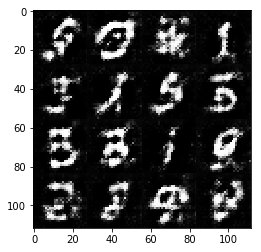

Epoch 1/2... Discriminator Loss: 1.4720... Generator Loss: 0.6764
Epoch 1/2... Discriminator Loss: 1.3584... Generator Loss: 0.8003
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.4806... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.3669... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.6848


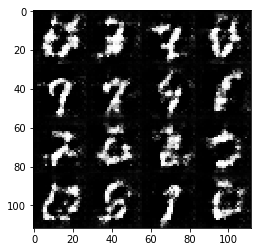

Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7236
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.4191... Generator Loss: 0.6945
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.7273
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.8702
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.8550


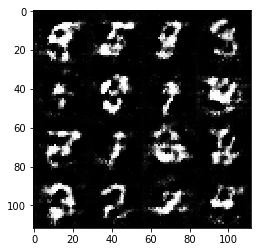

Epoch 1/2... Discriminator Loss: 1.6140... Generator Loss: 0.4832
Epoch 1/2... Discriminator Loss: 1.4793... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.3458... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.6431
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.9542
Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.7764
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.8016


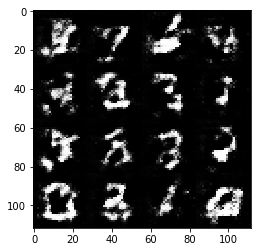

Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.6335
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.5173... Generator Loss: 0.6389
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.4408... Generator Loss: 0.7746
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.7146
Epoch 1/2... Discriminator Loss: 1.4724... Generator Loss: 0.7080
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.7079


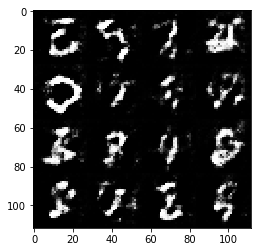

Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.7024
Epoch 1/2... Discriminator Loss: 1.5459... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.5022... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.7820


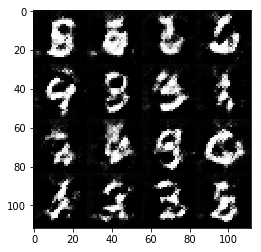

Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 1.5563... Generator Loss: 0.6672
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.7199
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 0.7198
Epoch 1/2... Discriminator Loss: 1.5318... Generator Loss: 0.6155
Epoch 1/2... Discriminator Loss: 1.4661... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.4382... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.6757


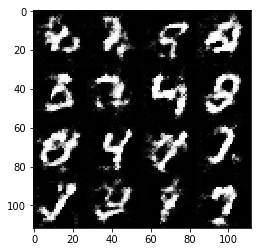

Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.4544... Generator Loss: 0.7948
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.6379
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.7552
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.4418... Generator Loss: 0.7185
Epoch 1/2... Discriminator Loss: 1.3922... Generator Loss: 0.8078
Epoch 1/2... Discriminator Loss: 1.4046... Generator Loss: 0.8140
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.7392
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.7942


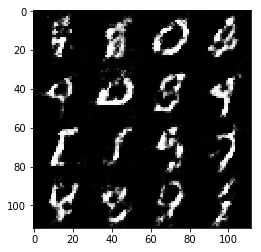

Epoch 1/2... Discriminator Loss: 1.5382... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.3489... Generator Loss: 0.8744
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 0.6975


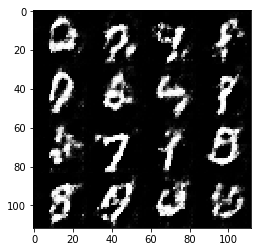

Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.6898... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 1.5685... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 1.4162... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.4330... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.8315


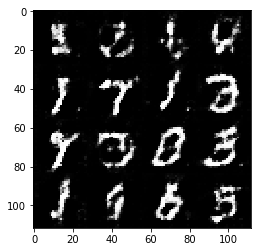

Epoch 1/2... Discriminator Loss: 1.4890... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.6886
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.7033
Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.7474
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.6822
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.4028... Generator Loss: 0.7327


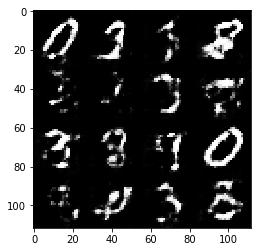

Epoch 2/2... Discriminator Loss: 1.4313... Generator Loss: 0.7261
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.7675
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.7242
Epoch 2/2... Discriminator Loss: 1.4524... Generator Loss: 0.7655
Epoch 2/2... Discriminator Loss: 1.4613... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.5144... Generator Loss: 0.6600
Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 1.4742... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.3402... Generator Loss: 0.8001


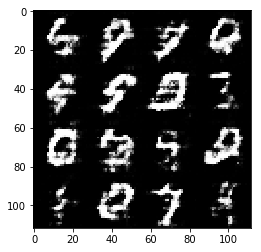

Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.8418
Epoch 2/2... Discriminator Loss: 1.5260... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.7274
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.7132
Epoch 2/2... Discriminator Loss: 1.4629... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.5004... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4762... Generator Loss: 0.7513


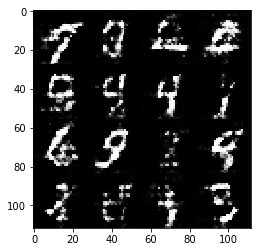

Epoch 2/2... Discriminator Loss: 1.4820... Generator Loss: 0.7097
Epoch 2/2... Discriminator Loss: 1.4254... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 1.4209... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.5363... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.3945... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.7476
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.6878


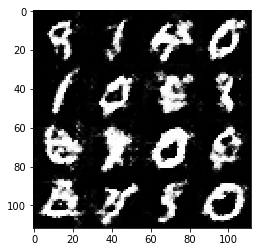

Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.7555
Epoch 2/2... Discriminator Loss: 1.3216... Generator Loss: 0.8247
Epoch 2/2... Discriminator Loss: 1.5139... Generator Loss: 0.7470
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 1.4778... Generator Loss: 0.6868
Epoch 2/2... Discriminator Loss: 1.5499... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.4408... Generator Loss: 0.7454
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.5961... Generator Loss: 0.6181


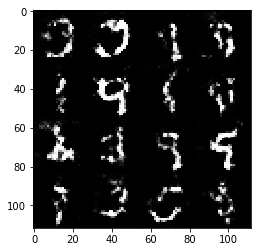

Epoch 2/2... Discriminator Loss: 1.5608... Generator Loss: 0.6430
Epoch 2/2... Discriminator Loss: 1.5519... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 1.5048... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 1.4236... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.6485... Generator Loss: 0.6074
Epoch 2/2... Discriminator Loss: 1.4783... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.4329... Generator Loss: 0.7032


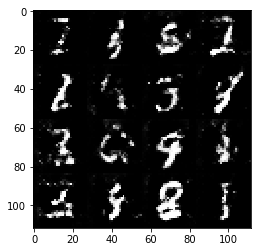

Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.8165
Epoch 2/2... Discriminator Loss: 1.3177... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.4796... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.3587... Generator Loss: 0.7680
Epoch 2/2... Discriminator Loss: 1.4834... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7821


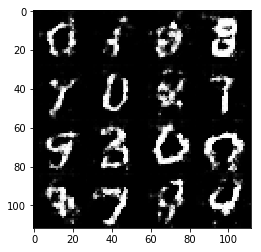

Epoch 2/2... Discriminator Loss: 1.4718... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.4112... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.7011
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.5334... Generator Loss: 0.6557
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7978
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.6781


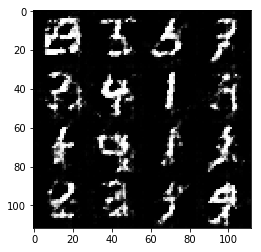

Epoch 2/2... Discriminator Loss: 1.4580... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.4371... Generator Loss: 0.7563
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.7163
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.7416
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.4710... Generator Loss: 0.7027
Epoch 2/2... Discriminator Loss: 1.6802... Generator Loss: 0.6180
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.7010
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.6691


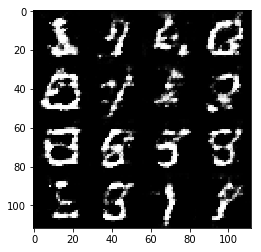

Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.4013... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.4592... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 1.4301... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.3922... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.7623
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.4578... Generator Loss: 0.7206


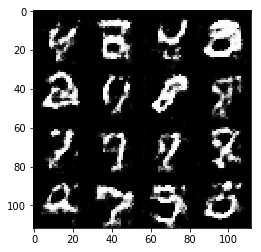

Epoch 2/2... Discriminator Loss: 1.5027... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.3987... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.3873... Generator Loss: 0.7621
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7788
Epoch 2/2... Discriminator Loss: 1.5185... Generator Loss: 0.6433
Epoch 2/2... Discriminator Loss: 1.5279... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.7342


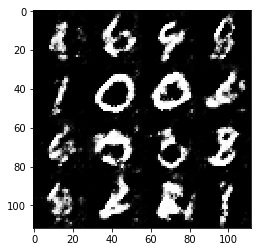

Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.7486
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.5158... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 1.4760... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 1.4928... Generator Loss: 0.6607
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.7345


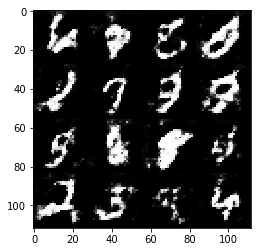

Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.4526... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 1.4296... Generator Loss: 0.7246
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.7121
Epoch 2/2... Discriminator Loss: 1.3546... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.4292... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.6836


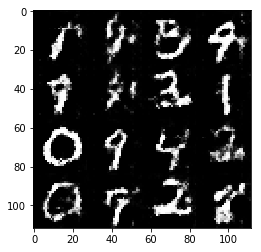

Epoch 2/2... Discriminator Loss: 1.4359... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 1.5311... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 1.3811... Generator Loss: 0.7853
Epoch 2/2... Discriminator Loss: 1.4823... Generator Loss: 0.7079
Epoch 2/2... Discriminator Loss: 1.4211... Generator Loss: 0.7294
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.4300... Generator Loss: 0.7600
Epoch 2/2... Discriminator Loss: 1.4230... Generator Loss: 0.6888
Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4995... Generator Loss: 0.6247


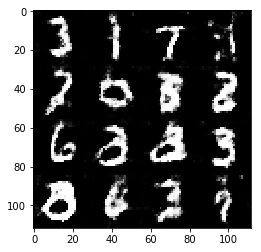

Epoch 2/2... Discriminator Loss: 1.4646... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.4199... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.4733... Generator Loss: 0.6824
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7408
Epoch 2/2... Discriminator Loss: 1.4477... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.5466... Generator Loss: 0.6777
Epoch 2/2... Discriminator Loss: 1.4983... Generator Loss: 0.7076


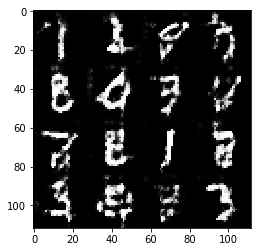

Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.7024
Epoch 2/2... Discriminator Loss: 1.4660... Generator Loss: 0.6670
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.4343... Generator Loss: 0.7269
Epoch 2/2... Discriminator Loss: 1.4023... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.5301... Generator Loss: 0.6829
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.7199


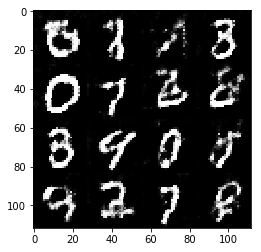

Epoch 2/2... Discriminator Loss: 1.3926... Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.7603
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.7200
Epoch 2/2... Discriminator Loss: 1.4890... Generator Loss: 0.7204
Epoch 2/2... Discriminator Loss: 1.4348... Generator Loss: 0.7422
Epoch 2/2... Discriminator Loss: 1.4648... Generator Loss: 0.7392
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.4447... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7680


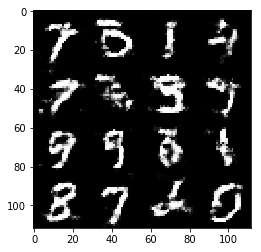

Epoch 2/2... Discriminator Loss: 1.4438... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3889... Generator Loss: 0.7708
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7895
Epoch 2/2... Discriminator Loss: 1.4753... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4222... Generator Loss: 0.7221
Epoch 2/2... Discriminator Loss: 1.4784... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 1.4863... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.6955


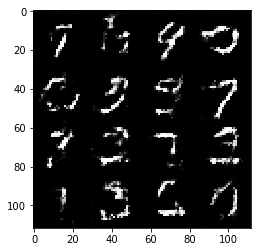

Epoch 2/2... Discriminator Loss: 1.4746... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.6960
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.6998
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.7577
Epoch 2/2... Discriminator Loss: 1.4480... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.4283... Generator Loss: 0.7084
Epoch 2/2... Discriminator Loss: 1.5058... Generator Loss: 0.7280


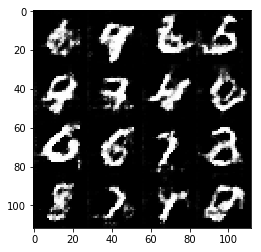

Epoch 2/2... Discriminator Loss: 1.4670... Generator Loss: 0.7622
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.7466
Epoch 2/2... Discriminator Loss: 1.4774... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.3794... Generator Loss: 0.7888
Epoch 2/2... Discriminator Loss: 1.3998... Generator Loss: 0.7814
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.7568


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.4557... Generator Loss: 0.0011
Epoch 1/1... Discriminator Loss: 6.0455... Generator Loss: 0.0037
Epoch 1/1... Discriminator Loss: 5.2118... Generator Loss: 0.0097
Epoch 1/1... Discriminator Loss: 3.9703... Generator Loss: 0.0360
Epoch 1/1... Discriminator Loss: 3.4544... Generator Loss: 0.0562
Epoch 1/1... Discriminator Loss: 3.6965... Generator Loss: 0.0454
Epoch 1/1... Discriminator Loss: 3.0943... Generator Loss: 0.0863
Epoch 1/1... Discriminator Loss: 2.7381... Generator Loss: 0.1138
Epoch 1/1... Discriminator Loss: 1.8400... Generator Loss: 0.3343


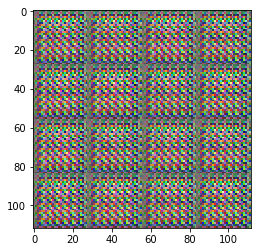

Epoch 1/1... Discriminator Loss: 1.9176... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.9438... Generator Loss: 0.3454
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.9004... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.9320
Epoch 1/1... Discriminator Loss: 2.0207... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 2.0969... Generator Loss: 0.5219


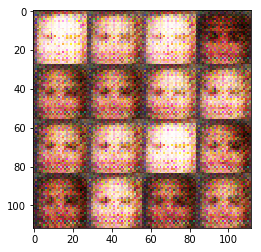

Epoch 1/1... Discriminator Loss: 1.7013... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.8321... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.7836... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.7093... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.7001... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.6999... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.7846... Generator Loss: 0.6033


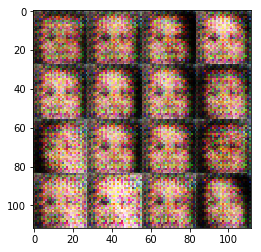

Epoch 1/1... Discriminator Loss: 1.7621... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.7755... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.8141... Generator Loss: 0.4858
Epoch 1/1... Discriminator Loss: 1.8740... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.9114... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.7558... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 2.0182... Generator Loss: 0.5499
Epoch 1/1... Discriminator Loss: 1.7544... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.8711... Generator Loss: 0.5509


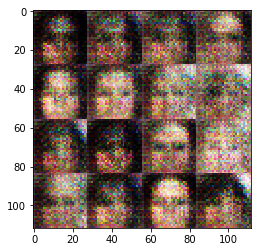

Epoch 1/1... Discriminator Loss: 1.8123... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.9763... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 0.5165
Epoch 1/1... Discriminator Loss: 1.9175... Generator Loss: 0.4742
Epoch 1/1... Discriminator Loss: 1.7369... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.7464... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.7226... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.6718


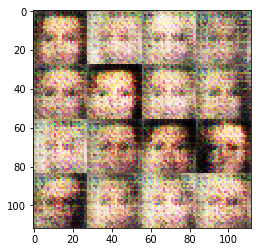

Epoch 1/1... Discriminator Loss: 1.6976... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.6385... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.7807... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 0.6352
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.7316... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.6501... Generator Loss: 0.5823


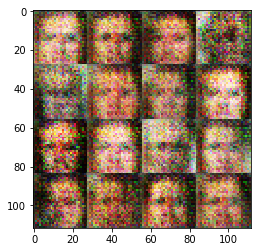

Epoch 1/1... Discriminator Loss: 1.6407... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.6563... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.7371... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.7069... Generator Loss: 0.5948


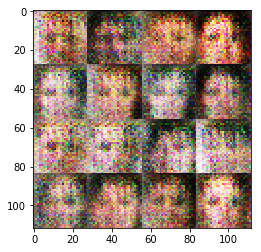

Epoch 1/1... Discriminator Loss: 1.5847... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.5855... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.7276... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.6495


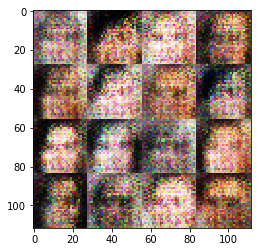

Epoch 1/1... Discriminator Loss: 1.6073... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.6039... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.5783... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.6577


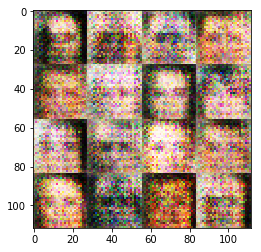

Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.5383... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.5811... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.5867... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.6647


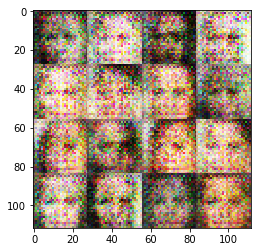

Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.7865


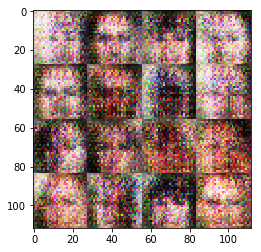

Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.5228... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.7337


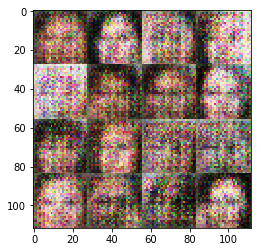

Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6982


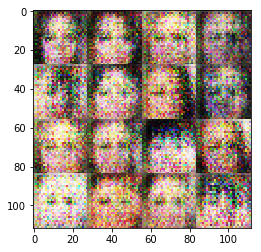

Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.5116... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6805
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 0.6900


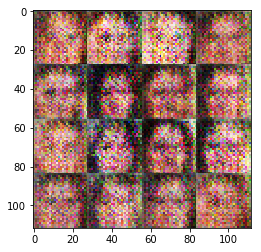

Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.5231... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7733


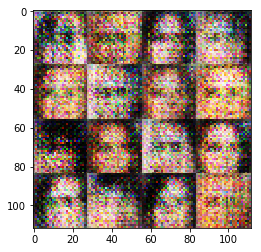

Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7055


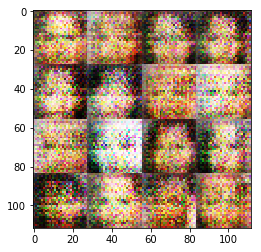

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.7367


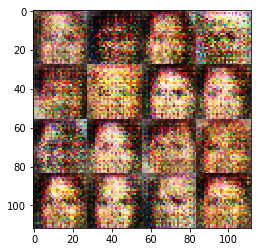

Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7455


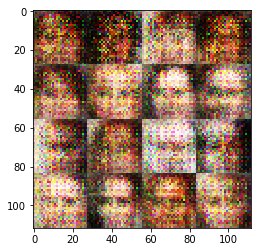

Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6531
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.6688


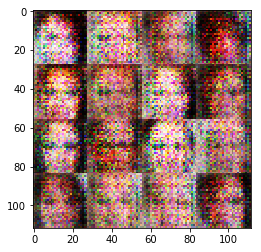

Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.5150... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6461


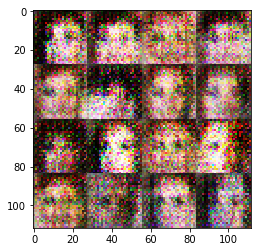

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.6770


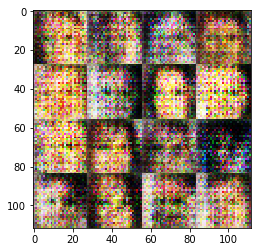

Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7644


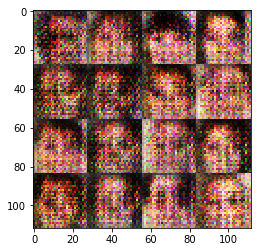

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.7486


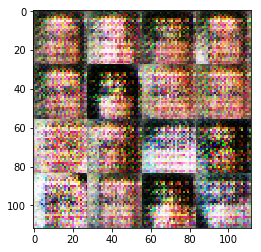

Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.7571


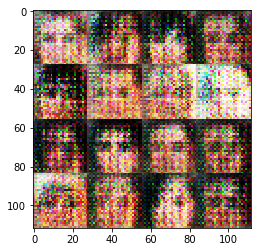

Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7735


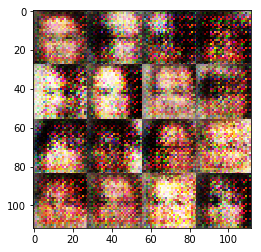

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7074


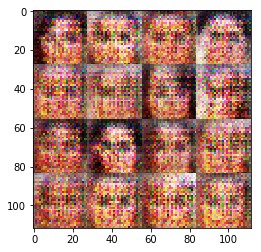

Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7476


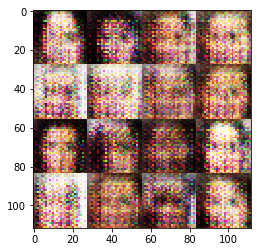

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7422


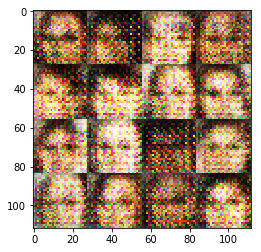

Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.7305


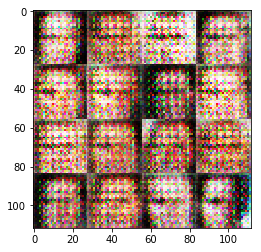

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7515


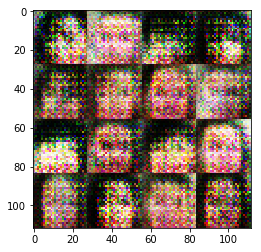

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7670


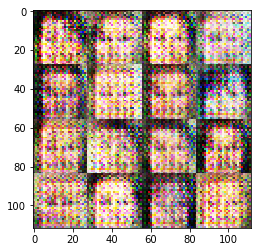

Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.8541


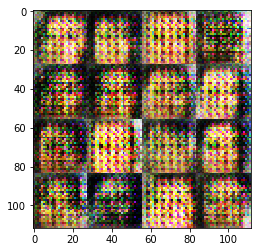

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7738


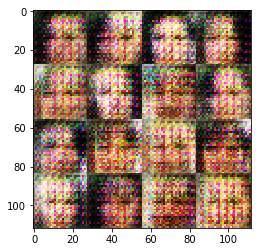

Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7362


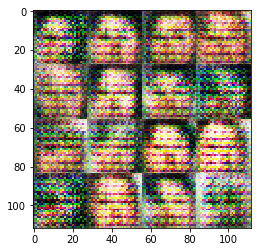

Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7740


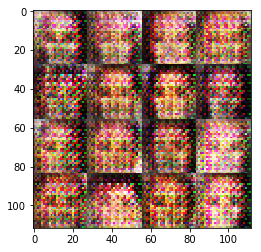

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7724


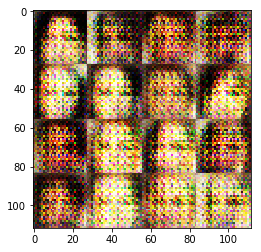

Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.6303


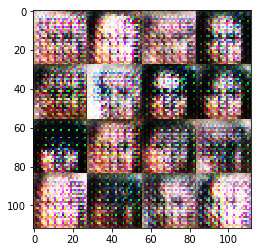

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.7243


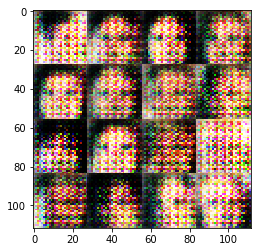

Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8092


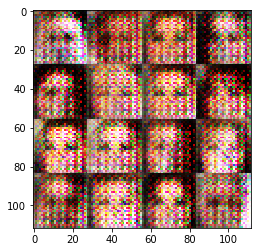

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.7875


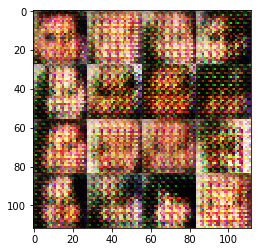

Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7853


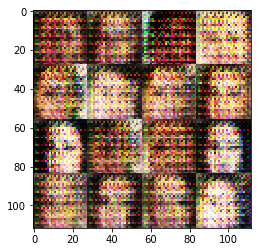

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7989


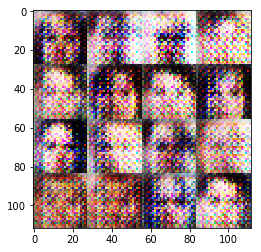

Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.7308


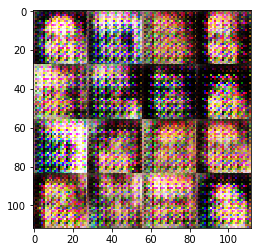

Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7952


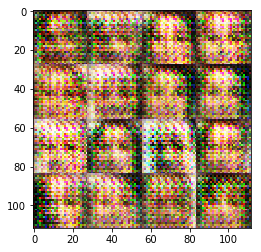

Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7492


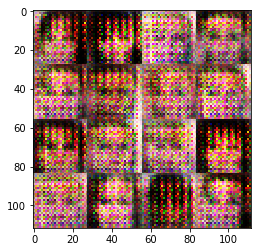

Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7838


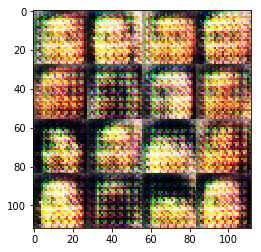

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8730
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7636


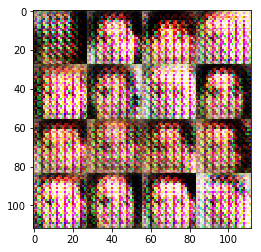

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7258


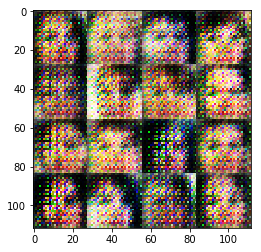

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7429


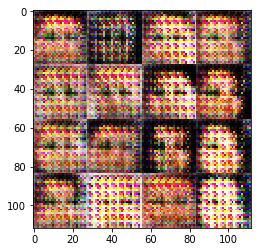

Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7658


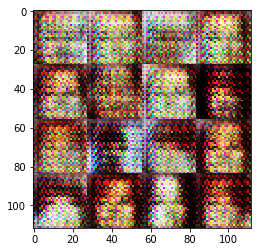

Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8083


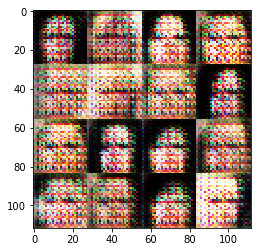

Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7335


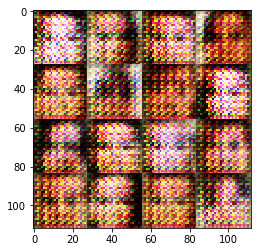

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7624


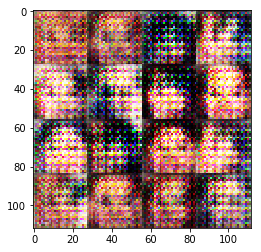

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.7616


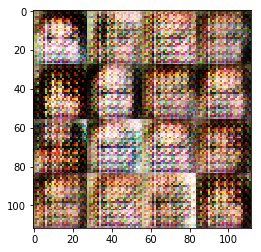

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8120


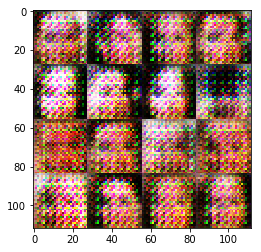

Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8572


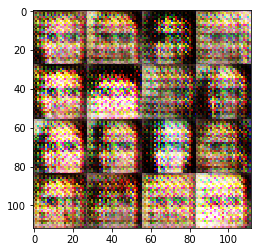

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7089


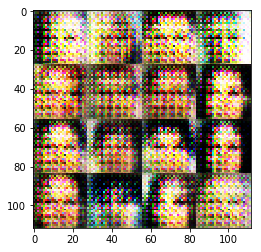

Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8001


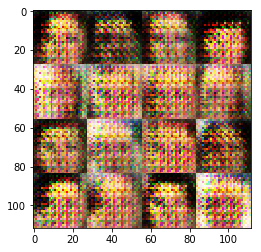

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7719


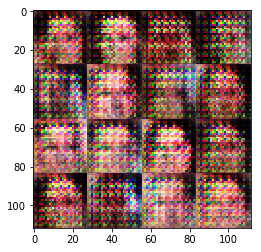

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8908


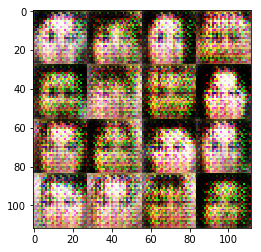

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7398


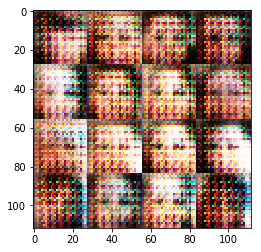

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7920


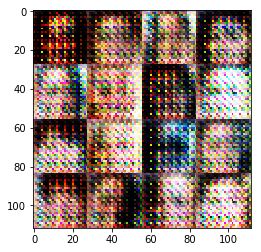

Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8415


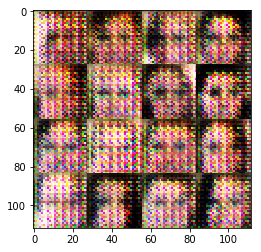

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7770


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.